In [49]:
!pip install evaluate
!pip install bert_score

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [11]:
wordnet

<WordNetCorpusReader in '.../corpora/wordnet' (not loaded yet)>

In [19]:
import json
from sklearn.metrics import accuracy_score
import evaluate
import numpy as np
import nltk
import subprocess
nltk.download('wordnet', download_dir='/kaggle/working/')
command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
subprocess.run(command.split())
nltk.data.path.append('/kaggle/working/')
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from tqdm import tqdm
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


# DAQUAR

In [13]:
answers_pred = json.load(open("/kaggle/input/daquar/Prediction.json"))

In [14]:
ground_truth, prediction = [], []
for answer_pred in answers_pred:
    gt, pred = ' '.join(answer_pred['answer'].split("_")), answer_pred['prediction']
    ground_truth.append(gt)
    prediction.append(pred)

## Accuracy

In [8]:
acc_score = accuracy_score(ground_truth, prediction)
print("Accuracy Score: ", acc_score)

Accuracy Score:  0.23099133782483156


## BLEU Score

In [17]:
bleu = evaluate.load("bleu")
bleu1 = bleu.compute(predictions=prediction, references=ground_truth, max_order = 1)
bleu2 = bleu.compute(predictions=prediction, references=ground_truth, max_order = 2)
bleu3 = bleu.compute(predictions=prediction, references=ground_truth, max_order = 3)
bleu4 = bleu.compute(predictions=prediction, references=ground_truth, max_order = 4)
print("BLEU 1 Score: ", bleu1['bleu'])
print("BLEU 2 Score: ", bleu2['bleu'])
print("BLEU 3 Score: ", bleu3['bleu'])
print("BLEU 4 Score: ", bleu4['bleu'])

BLEU 1 Score:  0.18392168169919043
BLEU 2 Score:  0.0814651535823478
BLEU 3 Score:  0.03793299499004017
BLEU 4 Score:  0.0


## BERTScore

In [24]:
bertscore = evaluate.load("bertscore")
score = bertscore.compute(predictions=prediction, references=ground_truth, lang='en')
bert_precision = np.average(score['precision'])
bert_recall = np.average(score['recall'])
bert_f1 = np.average(score['f1'])

print("BERT Precision: ", bert_precision)
print("BERT Recall: ", bert_recall)
print("BERT F1 Score: ", bert_f1)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Precision:  0.9452160083935893
BERT Recall:  0.9354311618661131
BERT F1 Score:  0.9395941117653527


In [25]:
answers_pred[0]

{'question': 'what is on the left side of the white oven on the floor and on right side of the blue armchair ?',
 'answer': 'garbage_bin',
 'image_dir': '/kaggle/input/daquar/DAQUAR/images/image1.png',
 'prediction': 'trash can'}

## WUPS Score

In [15]:
def wup(word1, word2, alpha):
    if word1 == word2:
        return 1.0

    w1 = wordnet.synsets(word1)
    w1_len = len(w1)
    if w1_len == 0: return 0.0
    w2 = wordnet.synsets(word2)
    w2_len = len(w2)
    if w2_len == 0: return 0.0

    #match the first
    word_sim = w1[0].wup_similarity(w2[0])
    if word_sim is None:
        word_sim = 0.0

    if word_sim < alpha:
        word_sim = 0.1*word_sim
    return word_sim


def wups(words1, words2, alpha):
    sim = 1.0
    flag = False
    for w1 in words1:
        max_sim = 0
        for w2 in words2:
            word_sim = wup(w1, w2, alpha)
            if word_sim > max_sim:
                max_sim = word_sim
        if max_sim == 0: continue
        sim *= max_sim
        flag = True
    if not flag:
        sim = 0.0
    return sim


def get_wups(pred, truth, alpha):
    pred = word_tokenize(pred)
    truth = word_tokenize(truth)
    item1 = wups(pred, truth, alpha)
    item2 = wups(truth, pred, alpha)
    value = min(item1, item2)
    return value

In [17]:
wups_score_0 = []
for i in tqdm(range(len(prediction))):
    gt, pred = ground_truth[i], prediction[i]
    wups_score_0.append(get_wups(pred, gt, 0.0))
print("WUPS Score at 0.0 Threshold: ", np.average(wups_score_0)*100)

100%|██████████| 12468/12468 [00:22<00:00, 556.04it/s]

WUPS Score at 0.0 Threshold:  58.122532736836185


In [18]:
wups_score_0_9 = []
for i in tqdm(range(len(prediction))):
    gt, pred = ground_truth[i], prediction[i]
    wups_score_0_9.append(get_wups(pred, gt, 0.9))
print("WUPS Score at 0.9 Threshold: ", np.average(wups_score_0_9)*100)

100%|██████████| 12468/12468 [00:16<00:00, 774.49it/s]

WUPS Score at 0.9 Threshold:  30.680829116769527


In [22]:
thresholds = [i/10 for i in range(11)]
wups_scores = []
for th in thresholds:
    wups_score = []
    for i in tqdm(range(len(prediction))):
        gt, pred = ground_truth[i], prediction[i]
        wups_score.append(get_wups(pred, gt, th))
    wups_scores.append(np.average(wups_score)*100)

100%|██████████| 12468/12468 [00:15<00:00, 791.42it/s]


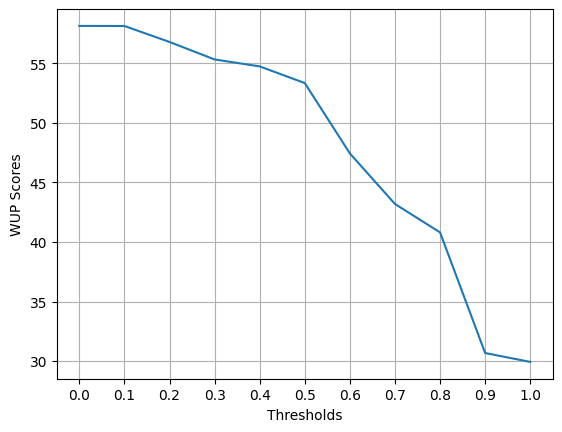

In [27]:
plt.plot(thresholds, wups_scores)
plt.grid(True)
plt.xlabel('Thresholds')
plt.ylabel('WUPS Scores')
plt.xticks(thresholds)
plt.show()

# VQA V2

In [44]:
data = {}
for i in tqdm(range(1, 11)):
    prediction_fold = json.load(open(f"/kaggle/input/vqa-v2/Predictions/Predictions/Fold_{i}_Pred.json"))
    for pred in prediction_fold:
        data[pred['question_id']] = {'answer_pred': pred['answer_pred']}
    ground_truth = json.load(open(f"/kaggle/input/vqa-v2/VQA_v2/VQA_v2/Folds/Answers/Fold_{i}.json"))
    for gt in ground_truth:
        data[gt['question_id']]['answer'] = gt['multiple_choice_answer']
        data[gt['question_id']]['answers'] = gt['answers']

100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


In [57]:
for d in data:
    print(data[d])
    break

{'answer_pred': 'net', 'answer': 'net', 'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 8}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 10}]}


In [46]:
ground_truth, prediction = [], []
for datapoint in data.values():
    ground_truth.append(datapoint['answer'])
    prediction.append(datapoint['answer_pred'])

In [58]:
ground_truth[:10]

['net',
 'pitcher',
 'orange',
 'yes',
 'white',
 'skiing',
 'red',
 'frisbee',
 'yes',
 'frisbee']

## Accuracy

In [47]:
acc_score = accuracy_score(ground_truth, prediction)
print("Accuracy Score: ", acc_score)

Accuracy Score:  0.7691168815365166


## BLEU Score

In [50]:
bleu = evaluate.load("bleu")
bleu1 = bleu.compute(predictions=prediction, references=ground_truth, max_order = 1)
bleu2 = bleu.compute(predictions=prediction, references=ground_truth, max_order = 2)
bleu3 = bleu.compute(predictions=prediction, references=ground_truth, max_order = 3)
bleu4 = bleu.compute(predictions=prediction, references=ground_truth, max_order = 4)
print("BLEU 1 Score: ", bleu1['bleu'])
print("BLEU 2 Score: ", bleu2['bleu'])
print("BLEU 3 Score: ", bleu3['bleu'])
print("BLEU 4 Score: ", bleu4['bleu'])

BLEU 1 Score:  0.7631290020115242
BLEU 2 Score:  0.5523985873438753
BLEU 3 Score:  0.43812746618516374
BLEU 4 Score:  0.3498809540999602


## BERTScore

In [52]:
bertscore = evaluate.load("bertscore")
score = bertscore.compute(predictions=prediction, references=ground_truth, lang='en')
bert_precision = np.average(score['precision'])
bert_recall = np.average(score['recall'])
bert_f1 = np.average(score['f1'])

print("BERT Precision: ", bert_precision)
print("BERT Recall: ", bert_recall)
print("BERT F1 Score: ", bert_f1)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Precision:  0.9858307854112189
BERT Recall:  0.9863845272640563
BERT F1 Score:  0.9859735391616475


## WUPS Score

In [53]:
def wup(word1, word2, alpha):
    if word1 == word2:
        return 1.0

    w1 = wordnet.synsets(word1)
    w1_len = len(w1)
    if w1_len == 0: return 0.0
    w2 = wordnet.synsets(word2)
    w2_len = len(w2)
    if w2_len == 0: return 0.0

    #match the first
    word_sim = w1[0].wup_similarity(w2[0])
    if word_sim is None:
        word_sim = 0.0

    if word_sim < alpha:
        word_sim = 0.1*word_sim
    return word_sim


def wups(words1, words2, alpha):
    sim = 1.0
    flag = False
    for w1 in words1:
        max_sim = 0
        for w2 in words2:
            word_sim = wup(w1, w2, alpha)
            if word_sim > max_sim:
                max_sim = word_sim
        if max_sim == 0: continue
        sim *= max_sim
        flag = True
    if not flag:
        sim = 0.0
    return sim


def get_wups(pred, truth, alpha):
    pred = word_tokenize(pred)
    truth = word_tokenize(truth)
    item1 = wups(pred, truth, alpha)
    item2 = wups(truth, pred, alpha)
    value = min(item1, item2)
    return value

In [54]:
wups_score_0 = []
for i in tqdm(range(len(prediction))):
    gt, pred = ground_truth[i], prediction[i]
    wups_score_0.append(get_wups(pred, gt, 0.0))
print("WUPS Score at 0.0 Threshold: ", np.average(wups_score_0)*100)

100%|██████████| 443757/443757 [06:26<00:00, 1149.17it/s]

WUPS Score at 0.0 Threshold:  86.57381836784151


In [55]:
wups_score_0_9 = []
for i in tqdm(range(len(prediction))):
    gt, pred = ground_truth[i], prediction[i]
    wups_score_0_9.append(get_wups(pred, gt, 0.9))
print("WUPS Score at 0.9 Threshold: ", np.average(wups_score_0_9)*100)

100%|██████████| 443757/443757 [03:42<00:00, 1997.45it/s]

WUPS Score at 0.9 Threshold:  79.48489717795285


In [ ]:
thresholds = [i/10 for i in range(11)]
wups_scores = []
for th in thresholds:
    wups_score = []
    for i in tqdm(range(len(prediction))):
        gt, pred = ground_truth[i], prediction[i]
        wups_score.append(get_wups(pred, gt, th))
    wups_scores.append(np.average(wups_score)*100)

In [ ]:
plt.plot(thresholds, wups_scores)
plt.grid(True)
plt.xlabel('Thresholds')
plt.ylabel('WUPS Scores')
plt.xticks(thresholds)
plt.show()